In [1]:
import numpy as np, xarray as xr, matplotlib.pyplot as plt, pandas as pd, s3fs, xesmf, time, pandas as pd, matplotlib as mpl
from utils import *
import dask.array as da
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster
import cartopy.crs as ccrs
from datetime import datetime
from ipywidgets import interact, interactive, fixed, interact_manual, widgets
%load_ext autoreload
%autoreload 2

# Observations

In [16]:
chlos_mon_sat = clip_to_region(xr.load_dataset('OBS-ESACCI-OC.nc'))

In [19]:
slider_map(chlos_mon_sat.chl, datetime(1997, 10, 1), datetime(2017, 10, 1))

interactive(children=(SelectionSlider(description='date', layout=Layout(width='800px'), options=(('1997-10', T…

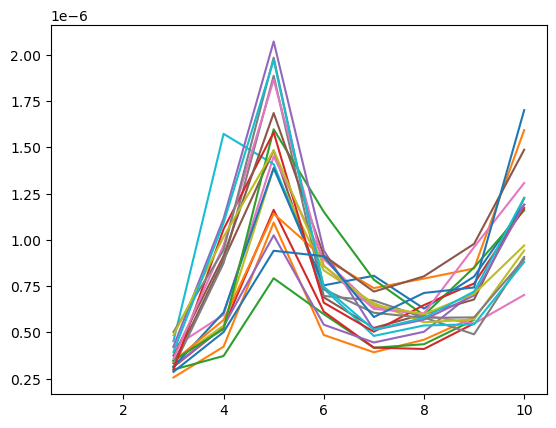

In [59]:
chlos_mon_sat_mean = chlos_mon_sat.chl.mean(dim = ('lat', 'lon'))
cms_m_g = chlos_mon_sat_mean.groupby('time.year')
[plt.plot(np.arange(1, len(cms_m_g[year]) + 1), cms_m_g[year]) for year in cms_m_g.groups.keys()]
plt.show()

# MODIS

In [24]:
def get_bucket_xyz_data(file):
    s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", 
                       client_kwargs=dict(endpoint_url="https://rgw.met.no"))
    base_path = 's3://escience2022/Ada/Modis/'
    ds = pd.read_table(s3.open(base_path + file), sep=' ', usecols=['lat', 'lon', 'value'], dtype=np.float32)
    ds['value'][ds['value'] < -1000] = np.nan
    ds = ds.drop(ds[ds.lat < 65].index)
    ds = ds.drop(ds[ds.lon < 0].index)
    ds = ds.drop(ds[ds.lon > 60].index)
    return ds

In [25]:
# s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", 
#                        client_kwargs=dict(endpoint_url="https://rgw.met.no"))

# chlos3 = pd.read_table(s3.open('s3://escience2022/Ada/Modis/vgpm.2002182.all.xyz'), sep=' ', usecols=['lat', 'lon', 'value'], dtype=np.float32)
# chlos3['value'][chlos3['value'] < -1000] = np.nan
# chlos3 = chlos3.drop(chlos3[chlos3.lat < 65].index)
# chlos3 = chlos3.drop(chlos3[chlos3.lon < 0].index)
# chlos3 = chlos3.drop(chlos3[chlos3.lon > 60].index)
chlos3 = get_bucket_xyz_data('vgpm.2002182.all.xyz')

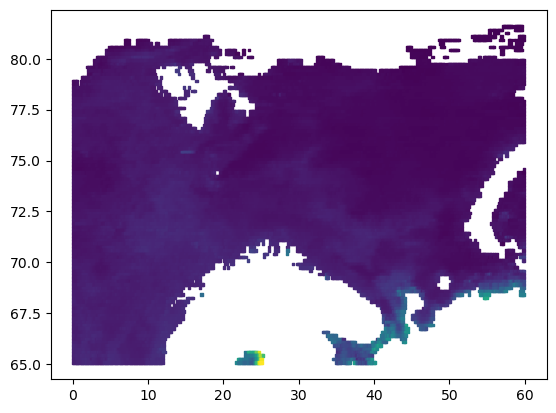

In [9]:

plt.scatter(chlos3.lon, chlos3.lat, c=chlos3.value, s=3, marker='s')
for i in range(12):
    plt.plot(np.arange(46), ds.dms.isel(year=i))

# NorESM2

In [2]:
start = time.time()
with ProgressBar():
    chlos_cesm = get_bucket_data(variable='chlos', time_res='daily', thing='Oday', model='CESM2', experiment='historical')
print(time.time() - start)

Request: s3://escience2022/Ada/daily/chlos_Oday_CESM2_historical_*.nc


/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'chlos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


4.475568056106567


In [3]:
chlos_cesm_clipped = clip_to_region(chlos_cesm.chlos, minlat=65, minlon=0, maxlon=70)

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1380: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [9]:
chlos1 = chlos_cesm_clipped.isel(time=slice(0, 10000))
chlos2 = chlos_cesm_clipped.isel(time=slice(10000, 20000))
chlos3 = chlos_cesm_clipped.isel(time=slice(20000, 30000))
chlos4 = chlos_cesm_clipped.isel(time=slice(30000, 40000))
chlos5 = chlos_cesm_clipped.isel(time=slice(40000, 50000))
chlos6 = chlos_cesm_clipped.isel(time=slice(50000, -1))

In [ ]:
chlos1.to_netcdf('chlos_cesm1')

In [ ]:
with ProgressBar():
    chlos_cesm_clipped.to_netcdf('chlos_CESM2_full')

[#############                           ] | 33% Completed | 40m 3ssss